Edwin Sanchez

# Data Discovery

This notebook attempts to look through the dataset to find interesting features.

> I "borrowed" a lot of code from the PyTorch Metric Learning's [Examples on Google Colab](https://github.com/KevinMusgrave/pytorch-metric-learning/blob/master/examples/README.md), specifically the [MNIST using SubCenterArcFaceLoss](https://github.com/KevinMusgrave/pytorch-metric-learning/blob/master/examples/notebooks/SubCenterArcFaceMNIST.ipynb) Notebook.

In [2]:
# Imports
import os
from tqdm import tqdm
import pandas as pd

## Define Useful Functions / Import Custom Functions

In [3]:
# Useful Functions / Custom Imports
from load_dataset import load_dataset_pd

## Read in Dataset

In [4]:
# Read in Dataset

# the directory containing the CIC-IDS2017 dataset
DATASET_DIR : str = "./CIC-IDS2017/"

# load the dataset
file_paths, dfs = load_dataset_pd ( dataset_dir = DATASET_DIR )

# print contents
for file_path, df in zip ( file_paths, dfs ):
    print ( f"File Path: { file_path }" )
    print ( df.head ( n = 2 ) )

Loading CSV file data from the directory './CIC-IDS2017/'.


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]

File Path: ./CIC-IDS2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   

    Fwd Packet Length Min   Fwd Packet Length Mean   Fwd Packet Length Std  \
0                       6                      6.0                     0.0   
1                       6                      6.0                     0.0   

   ...   min_seg_size_forward  Active Mean   Active Std   Active Max  \
0  ...                     20          0.0          0.0            0   
1  ...    

In [5]:
# list the columns in the csv file
# print ( dfs[0].columns )

for column in dfs[0].columns:
    print ( f"Number of Unique Elements: { df[column].nunique() } | Column: { column }" )

Number of Unique Elements: 14495 | Column:  Destination Port
Number of Unique Elements: 64077 | Column:  Flow Duration
Number of Unique Elements: 384 | Column:  Total Fwd Packets
Number of Unique Elements: 486 | Column:  Total Backward Packets
Number of Unique Elements: 5326 | Column: Total Length of Fwd Packets
Number of Unique Elements: 11163 | Column:  Total Length of Bwd Packets
Number of Unique Elements: 2569 | Column:  Fwd Packet Length Max
Number of Unique Elements: 123 | Column:  Fwd Packet Length Min
Number of Unique Elements: 12922 | Column:  Fwd Packet Length Mean
Number of Unique Elements: 18232 | Column:  Fwd Packet Length Std
Number of Unique Elements: 2718 | Column: Bwd Packet Length Max
Number of Unique Elements: 352 | Column:  Bwd Packet Length Min
Number of Unique Elements: 15876 | Column:  Bwd Packet Length Mean
Number of Unique Elements: 18464 | Column:  Bwd Packet Length Std
Number of Unique Elements: 87365 | Column: Flow Bytes/s
Number of Unique Elements: 68847 | 

In [6]:
# get destination ports, find the most heavily-trafficked ports

# Set N for the top N ports
num_top_ports : int = 5

# Find the top N destination ports with the most traffic
# the column names have
top_ports : pd.Series = df[' Destination Port'].value_counts().head ( num_top_ports )

print ( top_ports )

 Destination Port
53      58744
443     26935
80      16741
22        915
8080      778
Name: count, dtype: int64


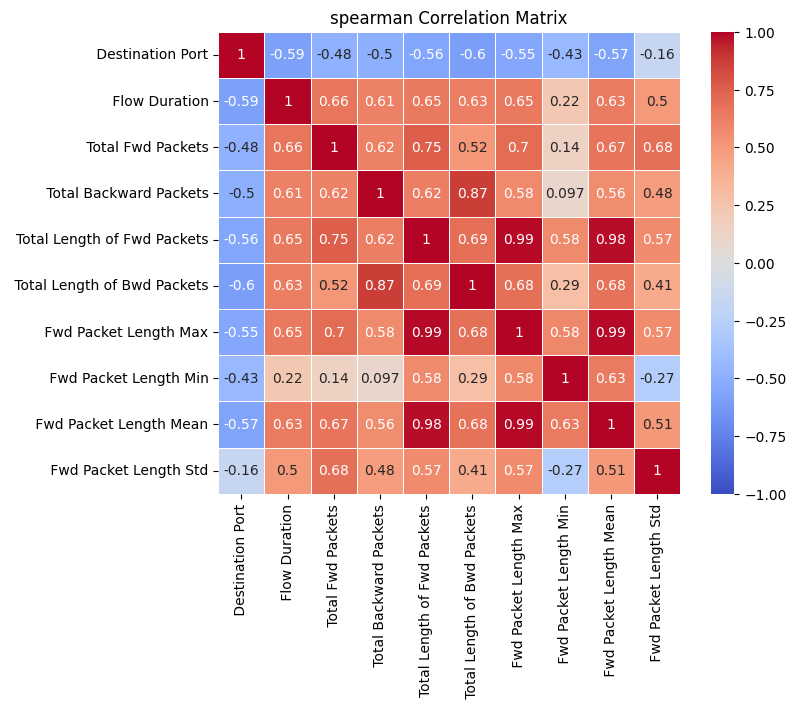

In [17]:
# Correlation Matrix
import seaborn as sns
import matplotlib.pyplot as plt

# drop a bunch of columns so we can see what's going on (too many)
N : int = 10
df_10_columns = df.iloc[:, :N]

# Calculate the correlation matrix
options : str = [ 'pearson', 'kendall', 'spearman']
method : str = options[2]
correlation_matrix = df_10_columns.corr(method=method)

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, square=True)

# Add title
plt.title(f'{method} Correlation Matrix')

# Show the plot
plt.show()

## Final Thoughts

Because Additive Angular Margin Loss requires *labels*, ie. it meant for **Supervised Learning**, I need to come up with my own labels for the dataset. The dataset conveniently comes with labels that tell us if the data is benign or not, but let's pretend we didn't have those (because the data we're working with doesn't have those).

My solution is to focus on destination ports. More specifically, I will pick the top N ports and use them as labels. That means each input sample will be classified by its destination port. Samples going to ports outside these top N ports will be ignored / tossed out.

I can then train the model to cluster traffic that goes to these ports. Once a clustering has been learned, we can examine the clusters, and see if we can distinguish outliers from the clusters on the test set.

> What are some issues with this approach? Hint: Supervised Learning Algorithm on an Unsupervised Learning problem...